In [ ]:
import torch
from torch import nn
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

1.   Creating a custom Dataset class by subclassing the Pytorch Dataset class and splitting the data into training and testing set based on the Partition value present in the annotation.csv file.
2.   Defining transformations for training and testing images (resizing, converting to tensor format and augmentations like random horizontal flips) .


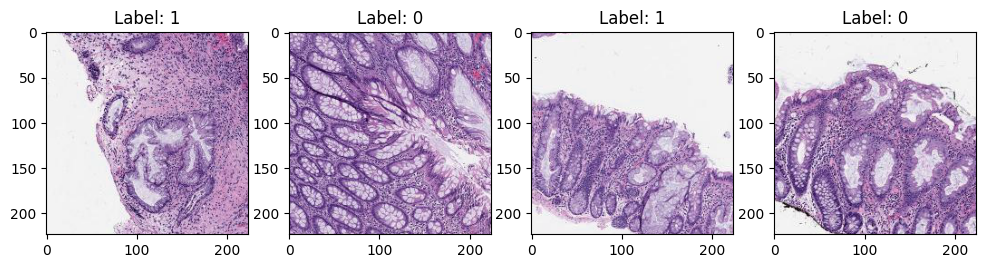

In [ ]:
#File paths
csv_path = '/content/drive/MyDrive/JJ/annotations.csv'
image_path = '/content/drive/MyDrive/JJ/images'

df = pd.read_csv(csv_path)

#Defining transformations for images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, image_folder, transform=None, partition='train'):
        self.df = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.transform = transform
        self.label_mapping = {"SSA": 1, "HP": 0}
        self.df_partition = self.df[self.df['Partition'] == partition]

    def __len__(self):
        return len(self.df_partition)

    def __getitem__(self, idx):
        img_name = self.df_partition.iloc[idx, 0]
        img_path = f"{self.image_folder}/{img_name}"

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        label_str = self.df_partition.iloc[idx, 1]
        label = self.label_mapping.get(label_str, -1)
        label = torch.tensor(label)

        return image, label

    def class_distribution(self):
      return self.df['Majority Vote Label'].value_counts()

    def print_dataset(self, num_samples=5):
        print(self.df.head(num_samples))


    def oversample_data(self):
      class_counts = self.df['Majority Vote Label'].value_counts()
      minority_class = class_counts.idxmin()
      minority_count = class_counts.min()

      # Oversampling the minority class
      majority_count = class_counts.max()
      oversampled_df = pd.concat([
          self.df[self.df['Majority Vote Label'] == minority_class],
          self.df[self.df['Majority Vote Label'] != minority_class].sample(majority_count - minority_count, replace=True)
      ], axis=0)

      # Shuffle the oversampled dataframe
      oversampled_df = oversampled_df.sample(frac=1).reset_index(drop=True)
      oversampled_dataset = CustomDataset(csv_path, image_path, transform=train_transform, partition='train')
      oversampled_dataset.df = oversampled_df

      return oversampled_dataset



train_dataset = CustomDataset(csv_path, image_path, transform=train_transform, partition='train')
test_dataset = CustomDataset(csv_path, image_path, transform=test_transform, partition='test')


# Create DataLoader
batch_size = 4
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Function to display images with labels
def show_images_batch(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))

    for i in range(len(images)):
        img = transforms.ToPILImage()(images[i])
        label = labels[i].item()

        axs[i].imshow(img)
        axs[i].set_title(f'Label: {label}')

    plt.show()

# Iterate through the DataLoader to visualize a batch of data
for batch in data_loader:
    images, labels = batch
    show_images_batch(images, labels)
    break


# Visualising Class Distribution


<ipython-input-4-bbba373f2d02>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


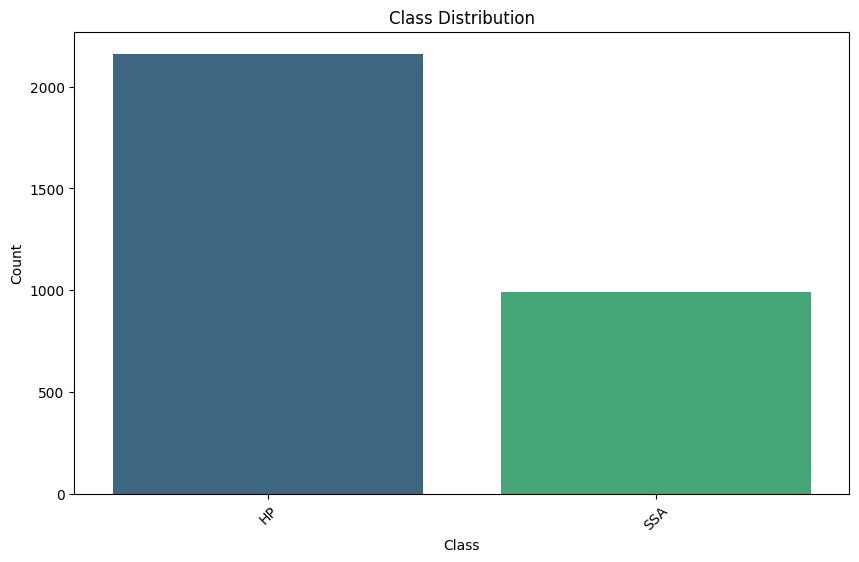

Class HP: 68.59%
Class SSA: 31.41%


In [ ]:
# Plotting the class distribution
class_counts = train_dataset.class_distribution()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Checking for class imbalance
total_samples = class_counts.sum()

percentage_distribution = {class_label: (count / total_samples) * 100 for class_label, count in class_counts.items()}

for class_label, percentage in percentage_distribution.items():
    print(f"Class {class_label}: {percentage:.2f}%")


The dataset exhibits class imbalance, with the majority class "HP" accounting for 68.59% of the samples, while the minority class "SSA" comprises 31.41%. To address this imbalance, I emplyed oversampling techniques to ensure a more equitable representation of both classes in the dataset.

---



# Oversampling

In [ ]:
train_df_oversampled = train_dataset.oversample_data()

<ipython-input-6-c3a899018962>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


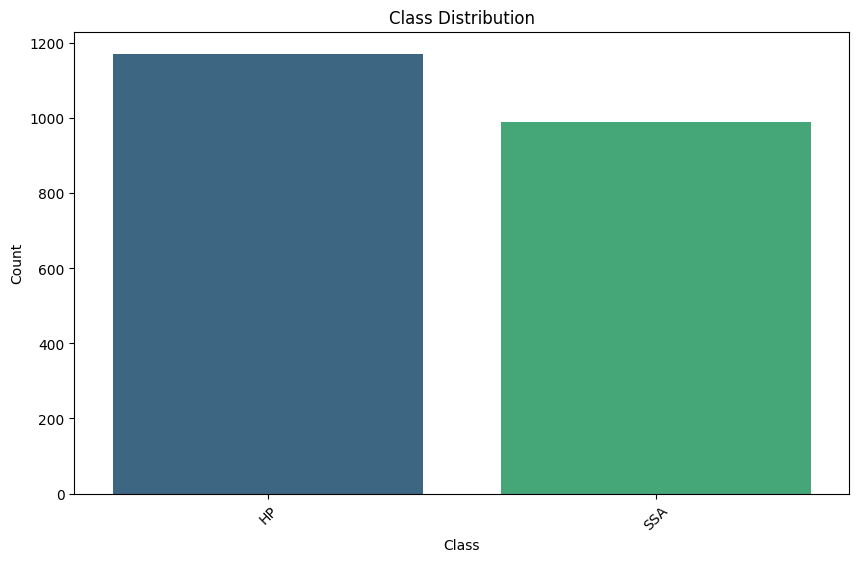

Class HP: 54.21%
Class SSA: 45.79%


In [ ]:
# Plot the class distribution
class_counts = train_df_oversampled.class_distribution()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Check for class imbalance
total_samples = class_counts.sum()  # Calculate total samples by summing up the counts

# Calculate percentage distribution
percentage_distribution = {class_label: (count / total_samples) * 100 for class_label, count in class_counts.items()}

# Print percentage distribution
for class_label, percentage in percentage_distribution.items():
    print(f"Class {class_label}: {percentage:.2f}%")


Following oversampling, the class distribution has been adjusted, with "HP" now representing 54.21% of the dataset, and "SSA" accounting for 45.79%.

#Training the Model

In [ ]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_df_oversampled, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the model
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.backbone = models.resnet18(pretrained=True)  #Using a pre-trained resnet-18 model
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

    def layer(self):
      return [self.backbone.layer4[-1]]

    def get_model(self):
      return self.backbone

num_classes = 2
model = Classifier(num_classes) #Initialising the model

criterion = nn.CrossEntropyLoss().  #Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   #Using Adam Optimizer

# Training loop
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:

      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.5624, Train Accuracy: 73.29%
Epoch 2/50, Train Loss: 0.4437, Train Accuracy: 79.17%
Epoch 3/50, Train Loss: 0.3563, Train Accuracy: 84.46%
Epoch 4/50, Train Loss: 0.3117, Train Accuracy: 85.89%
Epoch 5/50, Train Loss: 0.3085, Train Accuracy: 87.17%
Epoch 6/50, Train Loss: 0.2930, Train Accuracy: 87.40%
Epoch 7/50, Train Loss: 0.2287, Train Accuracy: 90.11%
Epoch 8/50, Train Loss: 0.2105, Train Accuracy: 92.05%
Epoch 9/50, Train Loss: 0.1972, Train Accuracy: 91.77%
Epoch 10/50, Train Loss: 0.1727, Train Accuracy: 93.38%
Epoch 11/50, Train Loss: 0.1748, Train Accuracy: 93.20%
Epoch 12/50, Train Loss: 0.1643, Train Accuracy: 93.52%
Epoch 13/50, Train Loss: 0.1485, Train Accuracy: 94.80%
Epoch 14/50, Train Loss: 0.1243, Train Accuracy: 95.54%
Epoch 15/50, Train Loss: 0.1109, Train Accuracy: 95.91%
Epoch 16/50, Train Loss: 0.0947, Train Accuracy: 96.14%
Epoch 17/50, Train Loss: 0.1097, Train Accuracy: 95.82%
Epoch 18/50, Train Loss: 0.0841, Train Accuracy: 96.83%
E

After training on 50 epochs, the train accuracy achieved by the resnet-18 model is 98.71%

# Saving the Model

In [ ]:
save_path = '/content/drive/MyDrive/JJ/save/model50.pth'

# Save the model
torch.save(model.get_model(), save_path)


# Model Evaluation

In [ ]:
model = torch.load("/content/drive/MyDrive/JJ/save/model50.pth")


# Evaluate the model on the test set
# model.cpu()  # Move model to CPU
model.eval()

correct = 0
total = 0
predicted_probs = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
      images = images.to('cuda')
      labels = labels.to('cuda')
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      predicted_probs.extend(torch.softmax(outputs, dim=1)[:, 1].tolist())
      true_labels.extend(labels.tolist())

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

# Calculate AUC
from sklearn.metrics import roc_auc_score

test_auc = roc_auc_score(true_labels, predicted_probs)
print(f"Test AUC: {test_auc:.4f}")


Accuracy on test set: 78.10%
Test AUC: 0.8834


The model achieved a test accuracy of 78%, and the test area under the receiver operating characteristic curve (AUC) is 0.8834.

In [ ]:
pip install grad_cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad_cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=97cf71e2a9ac044aa05f56a33f2756edd9967acb1b5bbb976f128f9f2e382f9a
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad_cam


# Using GradCam to generate heatmaps

In [ ]:
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

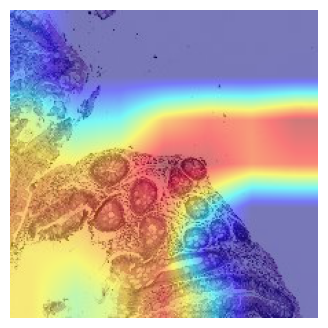

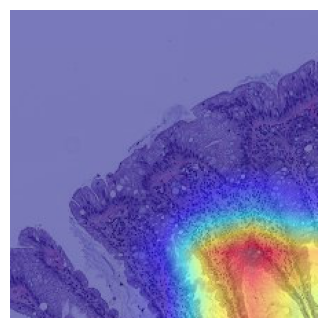

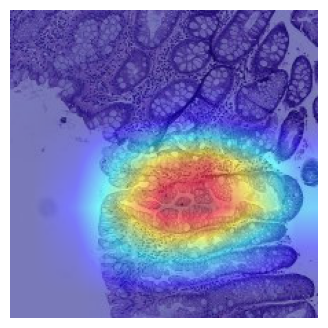

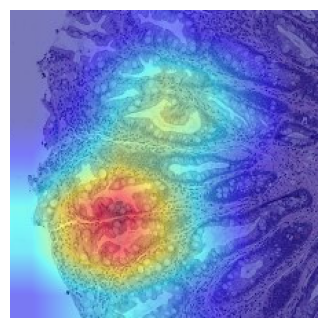

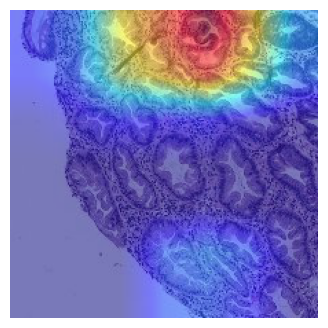

In [ ]:
import torchvision
import numpy as np

paths = ['/content/drive/MyDrive/JJ/images/MHIST_aag.png', '/content/drive/MyDrive/JJ/images/MHIST_aah.png', '/content/drive/MyDrive/JJ/images/MHIST_aaq.png', '/content/drive/MyDrive/JJ/images/MHIST_aar.png', '/content/drive/MyDrive/JJ/images/MHIST_aay.png']


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
for path in paths:

  rgb_img = Image.open(path).convert('RGB')

  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

  input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
  grayscale_cam = cam(input_tensor=input_tensor)

  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # Image.fromarray(visualization, 'RGB')
  plt.figure(figsize=(4, 4))
  plt.imshow(Image.fromarray(visualization, 'RGB'))
  plt.axis('off')
  plt.show()

